# Approximate Differential Privacy

```{admonition} Learning Objectives
After reading this chapter, you will be able to:
- Define approximate differential privacy
- Explain the differences between approximate and pure differential privacy
- Describe the advantages and disadvantages of approximate differential privacy
- Describe and calculate L1 and L2 sensitivity of vector-valued queries
- Define and apply the Gaussian mechanism
- Apply advanced composition
```

Approximate differential privacy {cite}`dwork2006`, also called $(\epsilon, \delta)$-differential privacy, has the following definition:

```{prf:definition}
\begin{align}
\mathsf{Pr}[F(x) = S] \leq e^\epsilon \mathsf{Pr}[F(x') = s] + \delta
\end{align}
```

The new privacy parameter, $\delta$, represents a "failure probability" for the definition. With probability $1-\delta$, we will get the same guarantee as pure differential privacy; with probability $\delta$, we get no guarantee. In other words:

- With probability $1-\delta$, $\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = s]} \leq e^\epsilon$
- With probability $\delta$, we get no guarantee at all

This definition should seem a little bit scary! With probability $\delta$, anything at all could happen - including a release of the entire sensitive dataset! For this reason, we typically require $\delta$ to be very small - usually $\frac{1}{n^2}$ or less, where $n$ is the size of the dataset. In addition, we'll see that the $(\epsilon, \delta)$-differentially private mechanisms in practical use don't fail catastrophically, as allowed by the definition - instead, they fail *gracefully*, and don't do terrible things like releasing the entire dataset.

Such mechanisms *are* possible, however, and they do satisfy the definition of $(\epsilon, \delta)$-differential privacy. We'll see an example of such a mechanism later in this section.

## Properties of Approximate Differential Privacy

Approximate differential privacy has similar properties to pure $\epsilon$-differential privacy. It satisfies **sequential composition**:

```{prf:theorem} Approximate-Sequential-Composition
:label: approximate-sequential-composition
- If $F_1(x)$ satisfies $(\epsilon_1, \delta_1)$-differential privacy
- And $F_2(x)$ satisfies $(\epsilon_2, \delta_2)$-differential privacy
- Then the mechanism $G(x) = (F_1(x), F_2(x))$ which releases both results satisfies $(\epsilon_1+\epsilon_2, \delta_1 + \delta_2)$-differential privacy
```

The only difference from the pure $\epsilon$ setting is that we add up the $\delta$s as well as the $\epsilon$s. Approximate differential privacy also satisfies post-processing and parallel composition.

## The Gaussian Mechanism

The Gaussian mechanism is an alternative to the Laplace mechanism, which adds Gaussian noise instead of Laplacian noise. The Gaussian mechanism does *not* satisfy pure $\epsilon$-differential privacy, but does satisfy $(\epsilon, \delta)$-differential privacy. According to the Gaussian mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $(\epsilon, \delta)$-differential privacy:

```{prf:definition}
\begin{align*}
F(x) = f(x) + \mathcal{N}(\sigma^2)\\
\text{where } \sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}
\end{align*}
```

where $s$ is the sensitivity of $f$, and $\mathcal{N}(\sigma^2)$ denotes sampling from the Gaussian (normal) distribution with center 0 and variance $\sigma^2$. Note that here (and elsewhere in these notes), $\log$ denotes the natural logarithm.

For real-valued functions $f : D \rightarrow \mathbb{R}$, we can use the Gaussian mechanism in exactly the same way as we do the Laplace mechanism, and it's easy to compare what happens under both mechanisms for a given value of $\epsilon$.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np

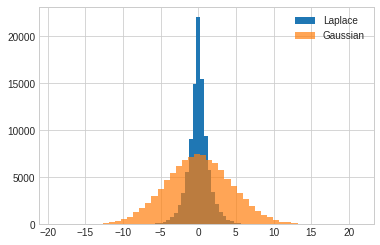

In [3]:
epsilon = 1
vals_laplace = [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]

delta = 10e-5
sigma = np.sqrt(2 * np.log(1.25 / delta)) * 1 / epsilon
vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]

plt.hist(vals_laplace, bins=50, label='Laplace')
plt.hist(vals_gauss, bins=50, alpha=.7, label='Gaussian');
plt.legend();

Here, we graph the empirical probability density function of the Laplace and Gaussian mechanisms for $\epsilon = 1$, with $\delta = 10^{-5}$ for the Gaussian mechanism.

Compared to the Laplace mechanism, the plot for the Gaussian mechanism looks "squished." Differentially private outputs which are far from the true answer are much more likely using the Gaussian mechanism than they are under the Laplace mechanism (which, by comparison, looks extremely "pointy").

So the Gaussian mechanism has two major drawbacks - it requires the use of the the relaxed $(\epsilon, \delta)$-differential privacy definition, *and* it's less accurate than the Laplace mechanism. Why would we want to use it?

## Vector-Valued Functions and their Sensitivities

So far, we have only considered real-valued functions (i.e. the function's output is always a single real number). Such functions are of the form $f : D \rightarrow \mathbb{R}$. Both the Laplace and Gaussian mechanism, however, can be extended to *vector-valued* functions of the form $f : D \rightarrow \mathbb{R}^k$, which return vectors of real numbers. We can think of histograms as vector-valued functions, which return a vector whose elements consist of histogram bin counts.

We saw earlier that the *sensitivity* of a function is:

\begin{align}
GS(f) = \max_{d(x,x') \leq 1} \lvert f(x) - f(x') \rvert
\end{align}

How do we define sensitivity for vector-valued functions?

Consider the expression $f(x) - f(x')$. If $f$ is a vector-valued function, then this expression represents the difference between two vectors, which can be computed as the difference between their corresponding elements (the difference of two length-$k$ vectors is thus a new length-$k$ vector). This new vector is the distance between $f(x)$ and $f(x')$, represented as a vector.

The magnitude of this vector is the sensitivity of $f$. There are several ways to compute the magnitude of a vector; we'll use two of them: the $L1$ norm and the $L2$ norm.

### L1 and L2 Norms

The $L1$ norm of a vector $V$ of length $k$ is defined as $\lVert V \rVert_1 = \sum_{i=1}^k \lvert V_i \rvert$ (i.e. it's the sum of the vector's elements). In 2-dimensional space, the $L1$ norm of the difference between two vectors yields the "manhattan distance" between them.

The $L2$ norm of a vector $V$ of length $k$ is defined as $\lVert V \rVert_2 = \sqrt{\sum_{i=1}^k V_i^2}$ (i.e. the square root of the sum of the squares). In 2-dimensional space, this is the "Euclidean distance", and it's always less than or equal to the $L1$ norm.

### L1 and L2 Sensitivities

The $L1$ sensitivity of a vector-valued function $f$ is:

```{prf:definition}
\begin{align*}
GS(f) = \max_{d(x,x') \leq 1} \lVert f(x) - f(x') \rVert_1
\end{align*}
```

This is equal to the sum of the *elementwise* sensitivities. For example, if we define a vector-valued function $f$ that returns a length-$k$ vector of 1-sensitive results, then the $L1$ sensitivity of $f$ is $k$.

Similarly, the $L2$ sensitivity of a vector-valued function $f$ is:

```{prf:definition}
\begin{align*}
GS_2(f) = \max_{d(x,x') \leq 1} \lVert f(x) - f(x') \rVert_2
\end{align*}
```

Using the same example as above, a vector-valued function $f$ returning a length-$k$ vector of 1-sensitive results has $L2$ sensitivity of $\sqrt{k}$. For long vectors, the $L2$ sensitivity will obviously be much lower than the $L1$ sensitivity! For some applications, like machine learning algorithms (which sometimes return vectors with thousands of elements), $L2$ sensitivity is *significantly* lower than $L1$ sensitivity.

### Choosing Between L1 and L2

As mentioned earlier, both the Laplace and Gaussian mechanisms can be extended to vector-valued functions. However, there's a key difference between these two extensions: the vector-valued Laplace mechanism **requires** the use of $L1$ sensitivity, while the vector-valued Gaussian mechanism allows the use of either $L1$ or $L2$ sensitivity. This is a major strength of the Gaussian mechanism. For applications in which $L2$ sensitivity is much lower than $L1$ sensitivity, the Gaussian mechanism allows adding *much* less noise.

- The **vector-valued Laplace mechanism** releases $f(x) + (Y_1, \dots, Y_k)$, where $Y_i$ are drawn i.i.d. from the Laplace distribution with scale $\frac{s}{\epsilon}$ and $s$ is the $L1$ sensitivity of $f$
- The **vector-valued Gaussian mechanism** releases $f(x) + (Y_1, \dots, Y_k)$, where $Y_i$ are drawn i.i.d. from the Gaussian distribution with $\sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}$ and $s$ is the $L2$ sensitivity of $f$

## The Catastrophe Mechanism

The definition of $(\epsilon, \delta)$-differential privacy says that a mechanism which satisfies the definition must "behave well" with probability $1-\delta$. That means that with probability $\delta$, the mechanism can do anything at all. This "failure probability" is concerning, because mechanisms which satisfy the relaxed definition may (with low probability) result in very bad outcomes.

Consider the following mechanism, which we will call the *catastrophe mechanism*:

```{prf:definition}
\begin{align}
F(q, x) =\;& \text{Sample a number $r$ from the uniform distribution between 0 and 1}\\
&\text{If } r < \delta, \text{return } x\\
&\text{Otherwise, return } q(x) + \text{Lap}(s/\epsilon), \text{where $s$ is the sensitivity of $q$}\\
\end{align}
```

With probability $1-\delta$, the catastrophe mechanism satisfies $\epsilon$-differential privacy. With probability $\delta$, it *releases the whole dataset with no noise*. This mechanism satisfies the definition of approximate differential privacy, but we probably wouldn't want to use it in practice.

Fortunately, most $(\epsilon, \delta)$-differentially private mechanisms don't have such a catastrophic failure mode. The Gaussian mechanism, for example, doesn't ever release the whole dataset. Instead, with probability $\delta$, the Gaussian mechanism doesn't *quite* satisfy $\epsilon$-differential privacy - it satisfies $c\epsilon$-differential privacy instead, for some value $c$. 

The Gaussian mechanism thus fails *gracefully*, rather than catastrophically, so it's reasonable to have far more confidence in the Gaussian mechanism than in the catastrophe mechanism. Later, we will see alternative relaxations of the definition of differential privacy which distinguish between mechanisms that fail gracefully (like the Gaussian mechanism) and ones that fail catastropically (like the catastrophe mechanism).

## Advanced Composition

We have already seen two ways of combining differentially private mechanisms: sequential composition and parallel composition. It turns out that $(\epsilon, \delta)$-differential privacy admits a new way of analyzing the sequential composition of differentially private mechanisms, which can result in a lower privacy cost.

The advanced composition theorem {cite}`dwork2010` is usually stated in terms of mechanisms which are instances of *$k$-fold adaptive composition*. 

```{prf:definition}
A $k$-fold adaptive composition is a sequence of mechanisms $m_1, \dots, m_k$ such that:

- Each mechanism $m_i$ may be chosen based on the outputs of all previous mechanisms $m_1, \dots, m_{i-1}$ (hence *adaptive*)
- The input to each mechanism $m_i$ is both the private dataset and all of the outputs of previous mechanisms (hence *composition*)
```

Iterative programs (i.e. loops or recursive functions) are nearly always instances of $k$-fold adaptive composition. A `for` loop that runs 1000 iterations, for example, is a 1000-fold adaptive composition. As a more specific example, an averaging attack is a $k$-fold adaptive composition:

In [8]:
# works for sensitivity-1 queries
def avg_attack(query, epsilon, k):
    results = [query + np.random.laplace(loc=0, scale=1/epsilon) for i in range(k)]
    return np.mean(results)

avg_attack(10, 1, 500)

10.070538197421769

In this example, the sequence of mechanisms is fixed ahead of time (we use the same mechanism each time), and $k = 500$. 

The standard sequential composition theorem says that the total privacy cost of this mechanism is $k\epsilon$ (in this case, $500 \epsilon$).

The advanced composition theorem says:

```{prf:theorem} Advanced-Composition
:label: advanced-composition
- If each mechanism $m_i$ in a $k$-fold adaptive composition $m_1, \dots, m_k$ satisfies $\epsilon$-differential privacy
- Then for any $\delta' \geq 0$, the entire $k$-fold adaptive composition satisfies $(\epsilon', \delta')$-differential privacy, where:

\begin{align}
\epsilon' = 2\epsilon \sqrt{2k \log(1/\delta')}
\end{align}
```

Plugging in $\epsilon = 1$ from the example above, and setting $\delta' = 10^{-5}$, we get:

\begin{align}
\epsilon' =& 2 \sqrt{1000 \log(100000)}\\
\approx& 214.59
\end{align}

So advanced composition derives a much lower bound on $\epsilon'$ than sequential composition, *for the same mechanism*.  What does this mean? It means that the bounds given by sequential composition are *loose* - they don't tightly bound the *actual* privacy cost of the computation. In fact, advanced composition also gives loose bounds - they're just slightly *less* loose than the ones given by sequential composition.

It's important to note that the two bounds are technically incomparable, since advanced composition introduces a $\delta$. When $\delta$ is small, however, we will often compare the $\epsilon$s given by both methods.

So, should we *always* use advanced composition? It turns out that we should *not*. Let's try the experiment above for different values of $k$, and graph the *total privacy cost* under both sequential composition and advanced composition.

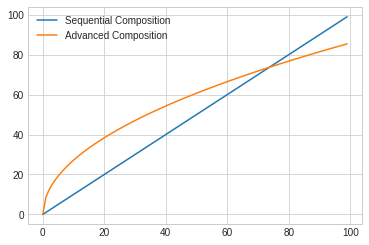

In [13]:
epsilon = 1
delta = 10e-5

def adv_comp(k):
    return 2*epsilon*np.sqrt(2*k*np.log(1/delta))

def seq_comp(k):
    return k*epsilon

plt.plot([seq_comp(k) for k in range(100)], label='Sequential Composition')
plt.plot([adv_comp(k) for k in range(100)], label='Advanced Composition')
plt.legend();

Standard sequential composition, it turns out, beats advanced composition for $k$ smaller than about 70. Thus, advanced composition is only really useful when $k$ is large (e.g. more than 100). When $k$ is very large, though, advanced composition can make a *big* difference.

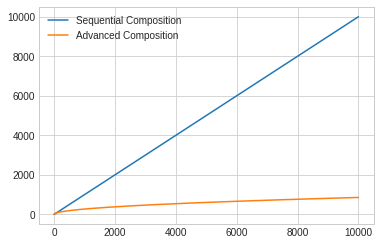

In [14]:
plt.plot([seq_comp(k) for k in range(10000)], label='Sequential Composition')
plt.plot([adv_comp(k) for k in range(10000)], label='Advanced Composition')
plt.legend();

## Advanced Composition for Approximate Differential Privacy

The description of advanced composition above requires the individual mechanisms being composed to satisfy pure $\epsilon$-differential privacy. However, the theorem also applies if they satisfy $(\epsilon, \delta)$-differential privacy instead. The more general statement of the advanced composition theorem is as follows ({cite}`dwork2010`, Theorem 3.20):

```{prf:theorem} Approximate-Advanced-Composition
:label: approximate-advanced-composition
- If each mechanism $m_i$ in a $k$-fold adaptive composition $m_1, \dots, m_k$ satisfies $(\epsilon, \delta)$-differential privacy
- Then for any $\delta' \geq 0$, the entire $k$-fold adaptive composition satisfies $(\epsilon', k\delta + \delta')$-differential privacy, where:

\begin{align}
\epsilon' = 2\epsilon \sqrt{2k \log(1/\delta')}
\end{align}
```

The only difference is in the failure parameter $\delta$ for the composed mechanism, where we have an additional $k\delta$ term. When the mechanisms being composed satisfy pure $\epsilon$-differential privacy, then $\delta = k\delta = 0$, and we get the same result as the statement above.